In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
DIR = "../input/h-and-m-personalized-fashion-recommendations"
transactions = pd.read_csv(os.path.join(DIR, "transactions_train.csv"))
articles = pd.read_csv(os.path.join(DIR, "articles.csv"))
customers = pd.read_csv(os.path.join(DIR, "customers.csv"))
#sample = pd.read_csv(os.path.join(DIR, "sample_submission.csv"))

**Starting with exploration of each dataset to get familiar with the data**

# Transactions Data

In [3]:
#Exploring the transactions data
transactions.head(3)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2


In [4]:
#checking column data types
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [5]:
#Change Transaction Date to appropriate datetime object
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions['t_dat']

0          2018-09-20
1          2018-09-20
2          2018-09-20
3          2018-09-20
4          2018-09-20
              ...    
31788319   2020-09-22
31788320   2020-09-22
31788321   2020-09-22
31788322   2020-09-22
31788323   2020-09-22
Name: t_dat, Length: 31788324, dtype: datetime64[ns]

* **Data spans from 20-09-2018 to 22-09-2020 covering 2 years of transactions which seems appropriate to count for seasonal fluctuations.**
* **Data includes more than 31 million transactions**
* **Costumer_id and Article_id are foreign keys used to join the data later on**


In [6]:
#Checking for missing values
transactions.isna().any()

t_dat               False
customer_id         False
article_id          False
price               False
sales_channel_id    False
dtype: bool

In [7]:
transactions.customer_id.value_counts()

be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
                                                                    ... 
63b70b71291668f0a63ade8e321fb3eccb80eba164f2087dad471de065f18e1f       1
950b172c36d169bf427545991fe66371f21a085799b44780fdcb2da6a3091613       1
7c284f13f4af9d6a53f97279381638ed0cb7afaa4fd4f3eaadc21993ea45fc69       1
62d49d0ae11a4f65fa31e354cb87f6b557ebec648e0e5e71435d2dd190d1ccc4       1
268eaa31a07d6f2f4f060bfcf32a660f3ea3dbb21ef14cd09fc2545f4e0b5c10       1
Name: customer_id, Length: 1362281, dtype: int64

Some customers bought a lot over the 2 year periods, and we have over 1.3 million unique customers among the total 3 million customers

In [8]:
transactions.article_id.value_counts()

706016001    50287
706016002    35043
372860001    31718
610776002    30199
759871002    26329
             ...  
520736002        1
619777003        1
586904003        1
512385003        1
533261032        1
Name: article_id, Length: 104547, dtype: int64

We have around a 100k unique items purchased

In [9]:
#Price column represent price per transaction
#Let's check out some characteristics
#prices are scaled in the dataset and do not show actual value
transactions.price.describe()


count    3.178832e+07
mean     2.782927e-02
std      1.918113e-02
min      1.694915e-05
25%      1.581356e-02
50%      2.540678e-02
75%      3.388136e-02
max      5.915254e-01
Name: price, dtype: float64

In [10]:
#How much difference there is in transactions prices?
maxmin = transactions.price.max()/transactions.price.min()
print('highest transaction price is %s times the lowest transaction price per date' % int(maxmin))

highest transaction price is 34900 times the lowest transaction price per date


<AxesSubplot:xlabel='t_dat'>

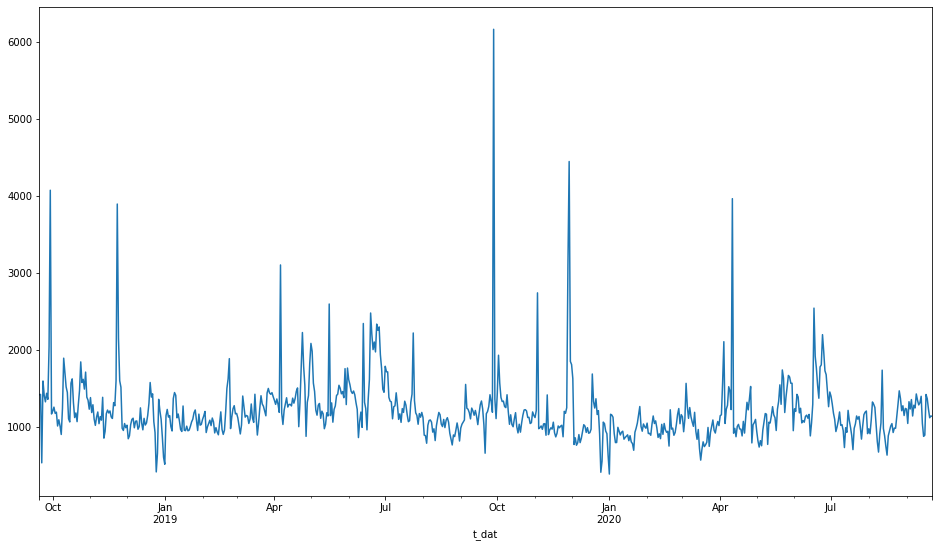

In [11]:
#plotting total transaction prices per date
transaction_per_date = transactions.groupby('t_dat')['price'].sum()
transaction_per_date.plot(figsize = (16,9))

**It seems like there is a spike in transaction values in certain dates, let's check them**

In [12]:
transaction_spike = transaction_per_date[transaction_per_date.values > 3000]
pd.Series(transaction_spike.values, transaction_spike.index.day_name())

t_dat
Saturday    4071.381305
Friday      3891.939441
Saturday    3100.904898
Saturday    6161.603068
Thursday    3103.027932
Friday      4444.342390
Saturday    3961.987763
dtype: float64

* We see some patterns in the spike, weekends are good days for H&M, especially the last saturday of september
* We will stop there for now, there is still much to explore like monthly fluctuations and days of week and holidays but they are outside the scope of this work

In [13]:
transactions.sales_channel_id.value_counts()

2    22379862
1     9408462
Name: sales_channel_id, dtype: int64

Sales channel represent the method of selling, either 2:ONLINE or 1:OFFLINE

# Customer Data

In [14]:
customers.head(7)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,NaN,NaN,ACTIVE,NONE,20.0,fe7b8e2b3fafb89ca90db17ffeeae0fd29b795d803f749...


In [15]:
customers.groupby('customer_id')['age'].mean()

customer_id
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657    49.0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa    25.0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318    24.0
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e    54.0
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a    52.0
                                                                    ... 
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831    24.0
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7    21.0
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264    21.0
ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a    18.0
ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241    65.0
Name: age, Length: 1371980, dtype: float64

In [16]:
#customers.dtypes
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [17]:
#checking for missing values
customers.isna().any()

customer_id               False
FN                         True
Active                     True
club_member_status         True
fashion_news_frequency     True
age                        True
postal_code               False
dtype: bool

We have lots of missing values, we will check explore each column and assess how to deal with each

In [18]:
#FN indicates if a customer get Fashion News newsletter
customers.FN.value_counts()

1.0    476930
Name: FN, dtype: int64

In [19]:
#FN represents if customer get Fashion News newsletter 1:yes, 0:no
#fiiling NA with 0 and converting values to integers
customers.FN = customers.FN.fillna(value=0).astype(int)

In [20]:
#Active indicates if the customer is active for communication
customers.Active.value_counts()

1.0    464404
Name: Active, dtype: int64

In [21]:
#Again filling missing values with 0 >>> 1:active, 0:not active
customers.Active = customers.Active.fillna(value=0).astype(int)

In [22]:
#checking whether a customer is a club member
customers.club_member_status.value_counts()

ACTIVE        1272491
PRE-CREATE      92960
LEFT CLUB         467
Name: club_member_status, dtype: int64

In [23]:
#How many missing values we have?
customers.club_member_status.isna().value_counts()

False    1365918
True        6062
Name: club_member_status, dtype: int64

In [24]:
#missing values seem to indicate a not a club member status so will fill it in as such
customers.club_member_status = customers.club_member_status.fillna(value='NOT_IN_CLUB')

In [25]:
#indicates how often a customer interacts with fashion news
customers.fashion_news_frequency.value_counts()

NONE         877711
Regularly    477416
Monthly         842
None              2
Name: fashion_news_frequency, dtype: int64

In [26]:
customers.fashion_news_frequency.isna().value_counts()

False    1355971
True       16009
Name: fashion_news_frequency, dtype: int64

In [27]:
#We have redundant NONE with different capitalisation, and we will deal with missing vaues as NONE as well
customers.fashion_news_frequency = customers.fashion_news_frequency.fillna(value='NONE')
customers.fashion_news_frequency = customers.fashion_news_frequency.replace('None','NONE')

In [28]:
#Age missing values is going to be tricky, will try different techniques after exploring the vaues
customers.age.isna().value_counts()

False    1356119
True       15861
Name: age, dtype: int64

<AxesSubplot:>

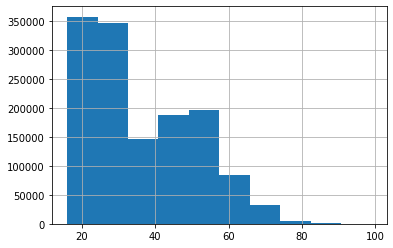

In [29]:
customers.age.hist()

In [30]:
customers[customers.age.isna()]

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,0,0,NOT_IN_CLUB,NONE,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
54,0002b9088196900626214bcdc6d5f3d85f38fb462a4806...,0,0,ACTIVE,NONE,NaN,db2cef710598164a99187237dd049b68502590eeb41ca3...
99,0004690d2b68d5175697d197a86065595ef7b49c7c051b...,0,0,PRE-CREATE,NONE,NaN,d831ea0a55a7a7af0e3ff9da0d370e225242bbc7999d78...
138,0005cd85a6220e1f1c582c7ff9175efe7d7c16d184c5ba...,0,0,ACTIVE,NONE,NaN,ee66d2b71f2fe333bee3e0f4a2dbac1fcf022e0df38763...
148,00060d2f1e63f2b95268b8573996b9aa5612a3efc97c71...,0,0,PRE-CREATE,NONE,NaN,f2288fb8f9b8ee2c3e56d6aa813d2a22f820cdfabf27a6...
...,...,...,...,...,...,...,...
1371583,ffecf38e80a8d73c9c6fb6db193e559dbd5374747b4b88...,0,0,PRE-CREATE,NONE,NaN,f1aed4d6848c484f218f9f9de2820c3f072ece21a043f4...
1371637,ffefa8fa76909f9b9b3c14680d3e00dae891de5d1522f9...,0,0,PRE-CREATE,NONE,NaN,d83ed3f6f943055853438d25031e896102bb960d07074a...
1371712,fff2f8b52ac6983cf9b2332d1a9bfe0ef38349a8d5392e...,0,0,ACTIVE,NONE,NaN,3802682b139e3cd0631970d555e4af072475e4dd92ea0a...
1371888,fffb069903e91c2ea4d665851b821c3f812e184119e5a8...,0,0,PRE-CREATE,NONE,NaN,0e6ad38084bfc681be59ae67f0225049cee4dfef044c29...


* **We can fill in age missing values with mean but I will postpone this until after I explore the article dataset, maybe purchase type might give a hint about the age group!**
* **Other columns do not seem to be good indicators of age**

# Article Data

In [44]:
articles.head(10)

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,detail_desc
0,108775015,108775,253,1010016,9,4,5,1676,A,1,16,1002,Jersey top with narrow shoulder straps.
1,108775044,108775,253,1010016,10,3,9,1676,A,1,16,1002,Jersey top with narrow shoulder straps.
2,108775051,108775,253,1010017,11,1,9,1676,A,1,16,1002,Jersey top with narrow shoulder straps.
3,110065001,110065,306,1010016,9,4,5,1339,B,1,61,1017,"Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,306,1010016,10,3,9,1339,B,1,61,1017,"Microfibre T-shirt bra with underwired, moulde..."
5,110065011,110065,306,1010016,12,1,11,1339,B,1,61,1017,"Microfibre T-shirt bra with underwired, moulde..."
6,111565001,111565,304,1010016,9,4,5,3608,B,1,62,1021,"Semi shiny nylon stockings with a wide, reinfo..."
7,111565003,111565,302,1010016,13,2,11,3608,B,1,62,1021,"Semi shiny nylon stockings with a wide, reinfo..."
8,111586001,111586,273,1010016,9,4,5,3608,B,1,62,1021,Tights with built-in support to lift the botto...
9,111593001,111593,304,1010016,9,4,5,3608,B,1,62,1021,"Semi shiny tights that shape the tummy, thighs..."


In [32]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

**seems like we only have missing values in the 'detail_desc' column**

In [33]:
articles.corr()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
article_id,1.000000,1.000000,-0.029674,0.007993,-0.064497,-0.048664,0.010208,-0.077247,-0.047474,-0.044521,-0.013408
product_code,1.000000,1.000000,-0.029674,0.007993,-0.064497,-0.048664,0.010208,-0.077247,-0.047474,-0.044521,-0.013408
product_type_no,-0.029674,-0.029674,1.000000,-0.001438,0.077929,-0.046910,-0.049135,-0.001921,0.067162,-0.118532,-0.461593
graphical_appearance_no,0.007993,0.007993,-0.001438,1.000000,0.016824,0.026956,0.019440,-0.000316,0.004883,0.011345,0.013072
colour_group_code,-0.064497,-0.064497,0.077929,0.016824,1.000000,0.066724,-0.177083,0.119798,0.035616,0.032955,-0.000316
perceived_colour_value_id,-0.048664,-0.048664,-0.046910,0.026956,0.066724,1.000000,0.027785,0.009986,0.032685,-0.004332,0.020732
perceived_colour_master_id,0.010208,0.010208,-0.049135,0.019440,-0.177083,0.027785,1.000000,-0.017224,-0.035996,-0.002461,-0.022573
department_no,-0.077247,-0.077247,-0.001921,-0.000316,0.119798,0.009986,-0.017224,1.000000,0.453340,0.349181,-0.053457
index_group_no,-0.047474,-0.047474,0.067162,0.004883,0.035616,0.032685,-0.035996,0.453340,1.000000,-0.077389,-0.144313
section_no,-0.044521,-0.044521,-0.118532,0.011345,0.032955,-0.004332,-0.002461,0.349181,-0.077389,1.000000,0.217788


In [34]:
#Dropping duplicate columns containing string values for speed
articles.drop(['prod_name', 'product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name',
               'perceived_colour_value_name', 'perceived_colour_master_name',
               'department_name', 'index_name',
               'index_group_name', 'section_name',
               'garment_group_name'], axis=1, inplace=True)

In [35]:
articles.head()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,detail_desc
0,108775015,108775,253,1010016,9,4,5,1676,A,1,16,1002,Jersey top with narrow shoulder straps.
1,108775044,108775,253,1010016,10,3,9,1676,A,1,16,1002,Jersey top with narrow shoulder straps.
2,108775051,108775,253,1010017,11,1,9,1676,A,1,16,1002,Jersey top with narrow shoulder straps.
3,110065001,110065,306,1010016,9,4,5,1339,B,1,61,1017,"Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,306,1010016,10,3,9,1339,B,1,61,1017,"Microfibre T-shirt bra with underwired, moulde..."


In [36]:
#Joining the data so we can do different kinds of groupings and study relationships in the data
merged = pd.merge(transactions, customers, on="customer_id")
merged = pd.merge(merged, articles, on="article_id")

In [37]:
merged.head()

,t_dat,customer_id,article_id,price,sales_channel_id,FN,Active,club_member_status,fashion_news_frequency,age,...,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,detail_desc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,0,0,ACTIVE,NONE,24.0,...,1010016,9,4,5,1338,B,1,61,1017,"Lace push-up body with underwired, moulded, pa..."
1,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,0,0,ACTIVE,NONE,24.0,...,1010016,9,4,5,1338,B,1,61,1017,"Lace push-up body with underwired, moulded, pa..."
2,2018-11-05,1385e5f3a2d3dbd21237f91faf81254a6d96de31b07b0b...,663713001,0.050831,2,0,0,ACTIVE,NONE,25.0,...,1010016,9,4,5,1338,B,1,61,1017,"Lace push-up body with underwired, moulded, pa..."
3,2018-11-05,1385e5f3a2d3dbd21237f91faf81254a6d96de31b07b0b...,663713001,0.050831,2,0,0,ACTIVE,NONE,25.0,...,1010016,9,4,5,1338,B,1,61,1017,"Lace push-up body with underwired, moulded, pa..."
4,2018-09-20,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,663713001,0.049475,2,1,1,ACTIVE,Regularly,30.0,...,1010016,9,4,5,1338,B,1,61,1017,"Lace push-up body with underwired, moulded, pa..."


In [38]:
merged.age.isna().value_counts()
merged.groupby('product_type_no')['age'].mean()

product_type_no
-1      35.441634
 49     36.263270
 57     33.769098
 59     33.234928
 60     39.041270
          ...    
 525    35.057851
 529    31.550273
 532    36.503248
 761    32.182222
 762    43.546875
Name: age, Length: 131, dtype: float64

There are some variations in average age buying batterns of specific product types, it is definitely a better indcicator of age missing values that just the mean of all values.
We will fill the missing age values with the appropriate age means

In [39]:
merged['age'] = merged['age'].fillna(merged.groupby('product_type_no')['age'].transform('mean'))
merged['age'] = merged.age.astype(int)

In [46]:
merged.age.isna().any()

False

In [41]:
merged.age.value_counts()

25    1580726
26    1576133
24    1501001
27    1482961
23    1352937
       ...   
99         98
93         95
94         61
97         38
96         31
Name: age, Length: 84, dtype: int64

It is recommended at times to do bins for the age groups. However, since there are a lot of records for each age, then it is best to keep it as a continuos value and avoid loss of information

In [42]:
#merged.corr()

In [43]:
from lightfm import LightFM